# **Churn Prediction Analysis**

In churn prediction, we assume that there are three phases of customer lifecycle :

- The ‘good’ phase [Month 6 & 7]
- The ‘action’ phase [Month 8]
- The ‘churn’ phase [Month 9]

In this case, since we are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

## instalation

In [ ]:
## imports
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pickle
import timeit, time


## Config
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.2f}'.format

# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### TPOT instalation

In [ ]:
# Instalation TPOT
!pip install deap update_checker tqdm stopit
!pip install tpot

     |████████████████████████████████| 163kB 3.4MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-cp36-none-any.whl size=11956 sha256=fe4ad7fefc1293856e33df82401afb3869f6922d242eb07bb2bec9d0e667eb4f
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built stopit
     |████████████████████████████████| 92kB 2.9MB/s 


## Load data

In [ ]:
df = pd.read_csv("clustered_dataset.csv",index_col="index")

In [ ]:
print(df.shape)
df.head()

(38744, 52)


,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,aon,sms_ic_6,sms_ic_7,sms_ic_8,sms_og_6,sms_og_7,sms_og_8,churn,days_since_last_rech_6,days_since_last_rech_7,days_since_last_rech_8,days_since_last_rech_data_6,days_since_last_rech_data_7,days_since_last_rech_data_8,count_2g3g,vol_2g3g,monthly_2g3g,segment
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
84848,7000457643,236.30,-34.84,12.10,91.98,0.00,0.00,51.89,24.51,20.16,0.00,0.00,0.00,31.63,24.51,20.16,112.24,0.00,0.00,41.54,0.00,0.00,5,8,2,0,200,0,0.00,0.00,0.00,0.00,0.00,0.00,17.40,1,29,15,23,20,21,1,14.00,1.00,11.00,60.00,60.00,60.00,0.00,0.00,0.00,3
17312,7000358270,1458.67,1228.95,1066.71,612.48,528.89,664.36,1133.36,886.24,475.01,0.00,0.00,0.00,0.00,0.00,0.00,1745.84,1415.14,1139.38,139.56,190.66,174.28,20,20,20,1690,1540,1140,0.00,0.00,0.00,0.00,0.00,0.00,14.00,28,10,24,2,14,16,0,3.00,1.00,0.00,60.00,60.00,60.00,0.00,0.00,0.00,1
9543,7002018260,792.93,737.75,989.00,675.19,988.23,347.06,424.44,450.69,368.41,0.00,0.00,187.98,0.00,0.00,311.44,1099.64,1438.93,404.03,154.63,121.79,47.89,8,15,4,1065,1340,435,2.00,1.00,1.00,121.00,23.00,198.00,14.50,13,28,20,14,2,14,0,1.00,0.00,0.00,1.00,24.00,26.00,0.50,518.76,0.50,2
16147,7001310138,669.20,770.72,860.42,42.28,25.91,22.19,377.84,617.39,1136.06,26.43,0.00,0.00,127.54,0.00,0.00,292.58,643.31,1158.26,151.83,196.39,278.58,10,10,12,894,817,1006,2.00,3.00,2.00,308.00,556.00,406.00,20.67,36,14,0,31,6,2,0,0.00,0.00,3.00,6.00,6.00,3.00,1.00,1179.22,1.00,2
38363,7001389270,1679.02,2171.11,2204.04,10.03,5.09,1.13,318.26,225.96,312.59,0.00,0.00,0.00,0.00,0.00,0.00,335.44,233.84,314.96,405.73,388.16,375.43,21,24,23,1953,2599,2547,11.00,13.00,7.00,1613.00,2271.00,2097.00,45.50,22,27,5,36,6,22,0,0.00,0.00,2.00,0.00,0.00,2.00,3.50,5384.47,3.50,2


### Export data

In [ ]:
allCol = df.columns.values
np.savetxt("AllColumns.csv", allCol, fmt="%5s",delimiter=",")

In [ ]:
seg1 = df[df["segment"]==1].iloc[:5,:]
seg2 = df[df["segment"]==2].iloc[:5,:]
seg3 = df[df["segment"]==3].iloc[:5,:]
segs = pd.concat([seg1,seg2,seg3],axis=0)

In [ ]:
segs.to_csv("clustered_dataset_sample.csv", index=False)

## Data Exploration

#### Churn vs non Churn

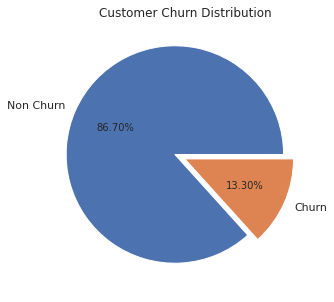

In [ ]:
churn_values = list(df['churn'].value_counts())
lab = ['Non Churn', 'Churn']
plt.figure(figsize = (7,5))
plt.pie(churn_values, labels = lab, explode = (0.1, 0), autopct = "%.2f%%")
plt.title('Customer Churn Distribution')
plt.show()

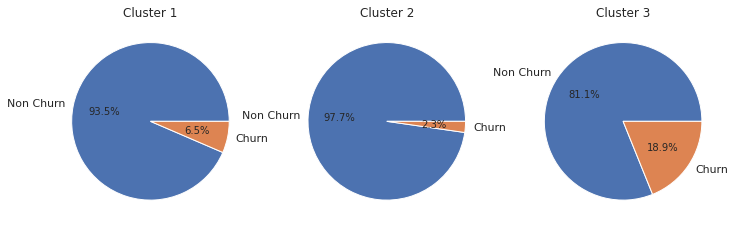

In [ ]:
dis = df[["segment","churn","mobile_number"]].groupby(["segment","churn"]).count()

fig, axes= plt.subplots(1,3, figsize=(12,7))
for i, ax in enumerate(axes.flatten()):
    ax.pie(dis.loc[i+1],
       autopct="%1.1f%%",
       radius = 1,
       labels= lab)
    ax.set_title("Cluster {0}".format(dis.index[i*2][0]))

plt.show()

#### Churn / AON

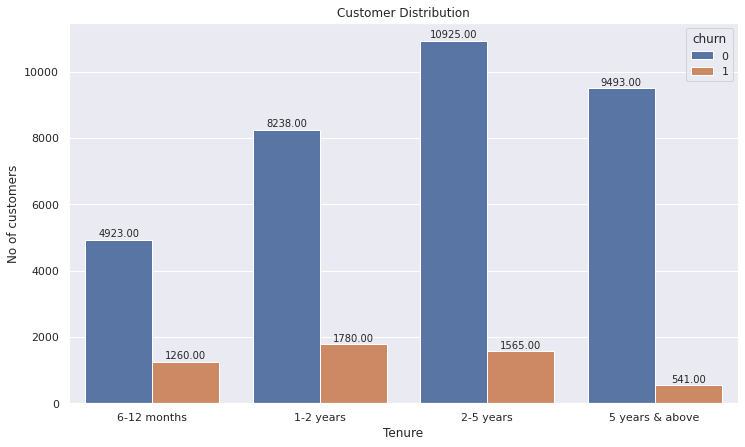

In [ ]:
ten_range = [6,12,24,60,150]
lab = ['6-12 months', '1-2 years', '2-5 years', '5 years & above']
tenure_range = pd.cut(df['aon'], [6,12,24,60,150], labels = lab)

plt.figure(figsize =(12,7))
count = sns.countplot(tenure_range, hue = df['churn'])
for x in count.patches:
    count.annotate(format(x.get_height(), '.2f'),(x.get_x() + x.get_width()/2., x.get_height()), ha = 'center', va = 'center',xytext = (0,6), textcoords = 'offset points' )
plt.xlabel('Tenure')
plt.ylabel('No of customers')
plt.title('Customer Distribution')
plt.show()

#### Data Correlation

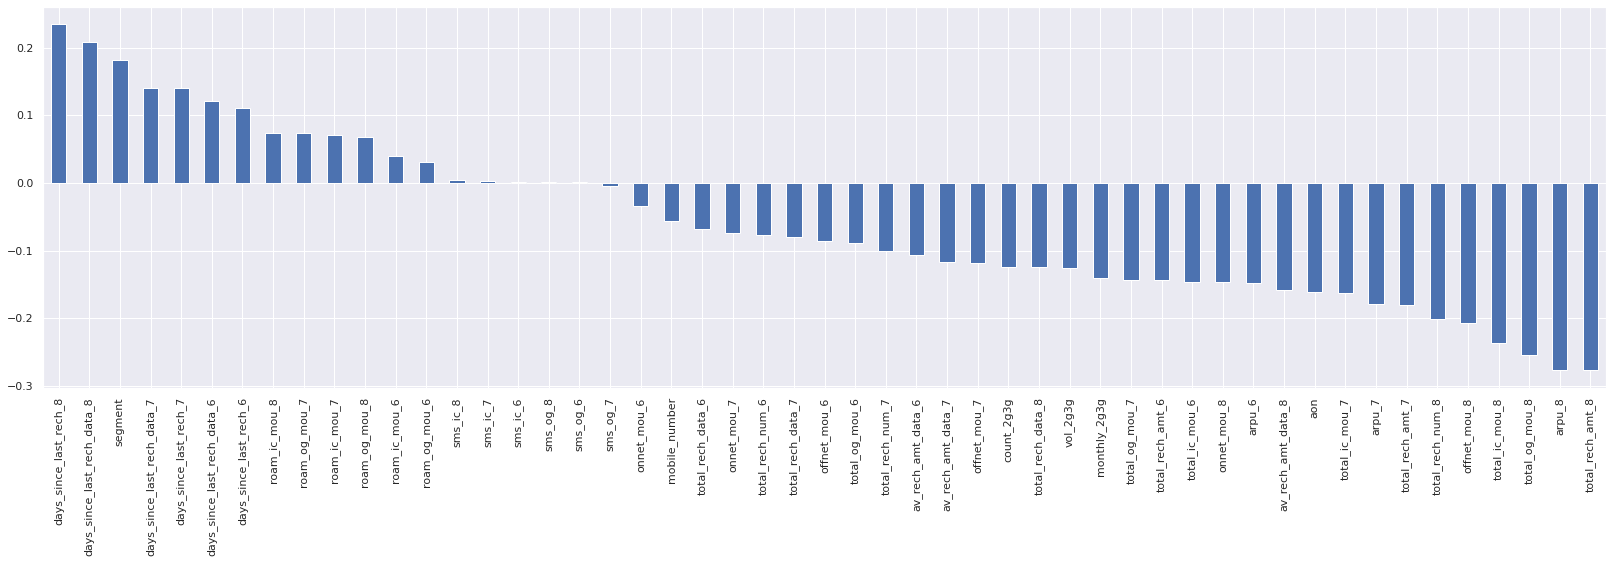

In [ ]:
## Correlation with churn column
corr = df.corr()['churn'].sort_values(ascending = False)
corr.drop(['churn'],inplace=True)
plt.figure(figsize = (28,7))
corr.plot(kind = 'bar')

# Modeling 

In [ ]:
from tpot import TPOTClassifier


for i,_df in enumerate(segments_data):

  start = timeit.default_timer()

  seg_num = _df['segment'].unique()[0]
  print("----------\n- segment n°{0}".format(seg_num))
  #if seg_num==1:

  # drop irrelevent columns
  _dfM = _df.drop(['mobile_number','segment'], axis=1)

  ### Split data to train/test data
  _dfM1 = _dfM[_dfM.churn==0]
  _dfM2 = _dfM[_dfM.churn==1]
  print("- Churners :",_dfM1.shape)
  print("- Non Churners :",_dfM2.shape)

  # split dataset to 70% Train data & 30% test data
  X_train1, X_test1 = train_test_split(_dfM1, test_size=0.3, train_size=0.7, random_state=1)
  X_train2, X_test2 = train_test_split(_dfM2, test_size=0.3, train_size=0.7, random_state=1)
  train = pd.concat([X_train1,X_train2],axis=0).sample(frac=1)
  test= pd.concat([X_test1,X_test2],axis=0).sample(frac=1)


  X_train = train.drop(['churn'], axis=1)
  y_train = train['churn']
  X_test = test.drop(['churn'], axis=1)
  y_test = test['churn']
  
  X_test.to_csv("test_seg{0}_Xtest.csv".format(seg_num), index=False)
  y_test.to_csv("test_seg{0}_Ytest.csv".format(seg_num), index=False)
  
  print("X_train Shape : ", X_train.shape)
  print("X_test Shape : ", X_test.shape)
  print("Imbalance in Train Data : ", (y_train != 0).sum()/(y_train == 0).sum())
  print("Imbalance in Test Data : ", (y_test != 0).sum()/(y_test == 0).sum())

  # Train model
  model = TPOTClassifier(
                          config_dict='TPOT light',
                          memory='auto',
                          template='Selector-Transformer-Classifier',
                          scoring='accuracy',
                          generations=1,
                          #max_time_mins=30,
                          #max_eval_time_mins=3,
                          verbosity=2
                          )
  model.fit(X_train, y_train)

  # Evaluate model
  y_pred = model.predict(X_test)
  test_acc = model.score(X_test, y_test)
  print("Test Accuracy score {0}".format(test_acc))
  print(classification_report(y_test, y_pred))
  print(confusion_matrix(y_test, y_pred))

  #calculate time
  print('-------------')
  stop = timeit.default_timer()
  print('Time: ', stop - start)  

  # Export model
  model.export('test_tpot_exported_pipeline{0}.py'.format(seg_num))
  pickle.dump(model.fitted_pipeline_,open('test_tpot_exported_model{0}.pickle'.format(seg_num),"wb"))
  print("\n_______________________________________________________________________\n\n\n")
  model = 0


----------
- segment n°3
- Churners : (19814, 50)
- Non Churners : (4615, 50)
X_train Shape :  (17099, 49)
X_test Shape :  (7330, 49)
Imbalance in Train Data :  0.23289350349700771
Imbalance in Test Data :  0.23296888141295205



Generation 1 - Current best internal CV score: 0.9326864836850828
Best pipeline: KNeighborsClassifier(PCA(VarianceThreshold(input_matrix, threshold=0.0005), iterated_power=10, svd_solver=randomized), n_neighbors=21, p=1, weights=distance)
Test Accuracy score 0.9368349249658936
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5945
           1       0.95      0.70      0.81      1385

    accuracy                           0.94      7330
   macro avg       0.94      0.85      0.88      7330
weighted avg       0.94      0.94      0.93      7330

[[5898   47]
 [ 416  969]]
-------------
Time:  1383.5989885339995

_______________________________________________________________________



----------
- segment n°1
- Churners : (4757, 50)
- Non Churners : (329, 50)
X_train Shape :  (3559, 49)
X_test Shape :  (1527, 49)
Imbalance in Train Data :  0.06908981676179032
Imbalance in Test Data :  0.06932773109243698



Generation 1 - Current best internal CV score: 0.9429597496799886
Best pipeline: DecisionTreeClassifier(MaxAbsScaler(SelectPercentile(input_matrix, percentile=40)), criterion=gini, max_depth=4, min_samples_leaf=8, min_samples_split=16)
Test Accuracy score 0.9358218729535036
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1428
           1       0.51      0.25      0.34        99

    accuracy                           0.94      1527
   macro avg       0.73      0.62      0.65      1527
weighted avg       0.92      0.94      0.93      1527

[[1404   24]
 [  74   25]]
-------------
Time:  108.85183136600062

_______________________________________________________________________



----------
- segment n°2
- Churners : (9020, 50)
- Non Churners : (209, 50)
X_train Shape :  (6460, 49)
X_test Shape :  (2769, 49)
Imbalance in Train Data :  0.023123218245169466
Imbalance in Test Data :  0.02328159645232816



Generation 1 - Current best internal CV score: 0.9814241486068112
Best pipeline: DecisionTreeClassifier(FeatureAgglomeration(VarianceThreshold(input_matrix, threshold=0.1), affinity=manhattan, linkage=average), criterion=gini, max_depth=2, min_samples_leaf=15, min_samples_split=8)
Test Accuracy score 0.9823040808956301
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2706
           1       0.89      0.25      0.40        63

    accuracy                           0.98      2769
   macro avg       0.94      0.63      0.69      2769
weighted avg       0.98      0.98      0.98      2769

[[2704    2]
 [  47   16]]
-------------
Time:  255.4638500789997

_______________________________________________________________________





In [ ]:
from tpot import TPOTClassifier

df_all = df.copy()

start = timeit.default_timer()

print("Before balancing : ",df_all.shape)

_df = df_all.drop(['mobile_number','segment'], axis=1)

### Split data to train/test data
for i in range(1,10000):
  if i in _df.index:
    if (_df.iloc[i].churn==0):
      _df= _df.drop(i,axis=0)

print("After balancing :",_df.shape)


### Split data to train/test data
_dfM1 = _df[_df.churn==0]
_dfM2 = _df[_df.churn==1]
print("- Non Churners :",_dfM1.shape)
print("- Churners",_dfM2.shape)


X_train1, X_test1 = train_test_split(_dfM1, test_size=0.3, train_size=0.7, random_state=1)
X_train2, X_test2 = train_test_split(_dfM2, test_size=0.3, train_size=0.7, random_state=1)
train = pd.concat([X_train1,X_train2],axis=0).sample(frac=1)
test= pd.concat([X_test1,X_test2],axis=0).sample(frac=1)

X_train = train.drop(['churn'], axis=1)
y_train = train['churn']
X_test = test.drop(['churn'], axis=1)
y_test = test['churn']

print("X_train Shape : ", X_train.shape)
print("X_test Shape : ", X_test.shape)

model = TPOTClassifier(
                      config_dict='TPOT light',
                      memory='auto',
                      template='Selector-Transformer-Classifier',
                      scoring='accuracy',
                      generations=1,
                      verbosity=2
                      )
model.fit(X_train, y_train)
print(model.score(X_test, y_test))
print( )
print(model.score(X_test, y_test))
print("_______________________________________________________________________")
print( )

# The evaluation metrics of our default model
y_pred = model.predict(X_test)

# Printing classification report
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# other context
test_acc = accuracy_score(y_test, y_pred)
print("Test Accuracy score {0}".format(test_acc))


#calculate time
print('-------------')
stop = timeit.default_timer()
print('Time: ', stop - start)  

Before balancing :  (38744, 52)
After balancing : (35317, 50)
- Non Churners : (30617, 50)
- Churners (4700, 50)
X_train Shape :  (24721, 49)
X_test Shape :  (10596, 49)



Generation 1 - Current best internal CV score: 0.9456736152695836
Best pipeline: DecisionTreeClassifier(MaxAbsScaler(VarianceThreshold(input_matrix, threshold=0.2)), criterion=entropy, max_depth=6, min_samples_leaf=11, min_samples_split=4)
0.9429029822574556

0.9429029822574556
_______________________________________________________________________

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      9186
           1       0.86      0.68      0.76      1410

    accuracy                           0.94     10596
   macro avg       0.91      0.83      0.86     10596
weighted avg       0.94      0.94      0.94     10596

[[9034  152]
 [ 453  957]]
Test Accuracy score 0.9429029822574556
-------------
Time:  2145.59855636


# Modeling with Clustering

### Split data to clusters

In [ ]:
segments_data = []

for seg in df['segment'].unique():
  segments_data.append(df[df['segment']==seg])


In [ ]:
for seg in reversed(segments_data):
  seg_num = seg['segment'].unique()[0]
  print('segment {0}:'.format(seg_num))
  print(seg.shape)

segment 2:
(9229, 52)
segment 1:
(5086, 52)
segment 3:
(24429, 52)


## Modeling

In [ ]:
from tpot import TPOTClassifier


for i,_df in enumerate(segments_data):

  seg_num = _df['segment'].unique()[0]
  print("----------\n- segment n°{0}".format(seg_num))
  if seg_num==3:

    # drop irrelevent columns
    _dfM = _df.drop(['mobile_number','segment'], axis=1)

    ### Split data to train/test data
    _dfM1 = _dfM[_dfM.churn==0]
    _dfM2 = _dfM[_dfM.churn==1]
    print("- Churners :",_dfM1.shape)
    print("- Non Churners :",_dfM2.shape)

    # split dataset to 70% Train data & 30% test data
    X_train1, X_test1 = train_test_split(_dfM1, test_size=0.3, train_size=0.7, random_state=1)
    X_train2, X_test2 = train_test_split(_dfM2, test_size=0.3, train_size=0.7, random_state=1)
    train = pd.concat([X_train1,X_train2],axis=0).sample(frac=1)
    test= pd.concat([X_test1,X_test2],axis=0).sample(frac=1)


    X_train = train.drop(['churn'], axis=1)
    y_train = train['churn']
    X_test = test.drop(['churn'], axis=1)
    y_test = test['churn']

    X_test.to_csv("seg{0}_Xtest.csv".format(seg_num), index=False)
    y_test.to_csv("seg{0}_Ytest.csv".format(seg_num), index=False)

    print("X_train Shape : ", X_train.shape)
    print("X_test Shape : ", X_test.shape)
    print("Imbalance in Train Data : ", (y_train != 0).sum()/(y_train == 0).sum())
    print("Imbalance in Test Data : ", (y_test != 0).sum()/(y_test == 0).sum())

    # Train model
    model = TPOTClassifier(
                            config_dict='TPOT light',
                            memory='auto',
                            template='Selector-Transformer-Classifier',
                            scoring='accuracy',
                            max_time_mins=30,
                            max_eval_time_mins=3,
                            verbosity=2
                            )
    model.fit(X_train, y_train)

    # Evaluate model
    y_pred = model.predict(X_test)
    test_acc = model.score(X_test, y_test)
    print("Test Accuracy score {0}".format(test_acc))
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

    # Export model
    model.export('tpot_exported_pipeline{0}.py'.format(seg_num))
    pickle.dump(model.fitted_pipeline_,open('tpot_exported_model{0}.pickle'.format(seg_num),"wb"))
    print("\n_______________________________________________________________________\n\n\n")

----------
- segment n°3
- Churners : (19814, 50)
- Non Churners : (4615, 50)
X_train Shape :  (17099, 49)
X_test Shape :  (7330, 49)
Imbalance in Train Data :  0.23289350349700771
Imbalance in Test Data :  0.23296888141295205



Generation 1 - Current best internal CV score: 0.9329199742067462
30.25 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: KNeighborsClassifier(ZeroCount(VarianceThreshold(input_matrix, threshold=0.0001)), n_neighbors=14, p=2, weights=distance)
Test Accuracy score 0.9345156889495225
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      5945
           1       0.93      0.71      0.80      1385

    accuracy                           0.93      7330
   macro avg       0.93      0.85      0.88      7330
weighted avg       0.93      0.93      0.93      7330

[[5869   76]
 [ 404  981]]

_______________________________________________________________________



----------
- segment n°1
----------
- segment n°2


#  Modeling without Clustering

## Modeling

In [ ]:
from tpot import TPOTClassifier

df_all = df.copy()
print("Before balancing : ",df_all.shape)

_df = df_all.drop(['mobile_number','segment'], axis=1)

### Split data to train/test data
for i in range(1,10000):
  if i in _df.index:
    if (_df.iloc[i].churn==0):
      _df= _df.drop(i,axis=0)

print("After balancing :",_df.shape)


### Split data to train/test data
_dfM1 = _df[_df.churn==0]
_dfM2 = _df[_df.churn==1]
print("- Non Churners :",_dfM1.shape)
print("- Churners",_dfM2.shape)


X_train1, X_test1 = train_test_split(_dfM1, test_size=0.3, train_size=0.7, random_state=1)
X_train2, X_test2 = train_test_split(_dfM2, test_size=0.3, train_size=0.7, random_state=1)
train = pd.concat([X_train1,X_train2],axis=0).sample(frac=1)
test= pd.concat([X_test1,X_test2],axis=0).sample(frac=1)

X_train = train.drop(['churn'], axis=1)
y_train = train['churn']
X_test = test.drop(['churn'], axis=1)
y_test = test['churn']


X_test.to_csv("global_Xtest.csv", index=False)
y_test.to_csv("global_Ytest.csv", index=False)

print("X_train Shape : ", X_train.shape)
print("X_test Shape : ", X_test.shape)

Before balancing :  (38744, 52)
After balancing : (35317, 50)
- Non Churners : (30617, 50)
- Churners (4700, 50)
X_train Shape :  (24721, 49)
X_test Shape :  (10596, 49)


In [ ]:
model = TPOTClassifier(
                      config_dict='TPOT light',
                      memory='auto',
                      template='Selector-Transformer-Classifier',
                      scoring='accuracy',
                      max_time_mins=6,
                      max_eval_time_mins=5,
                      verbosity=2
                      )
model.fit(X_train, y_train)
print(model.score(X_test, y_test))
model.export('tpot_exported_pipeline_global.py')
pickle.dump(model.fitted_pipeline_,open('tpot_exported_model_global.pickle',"wb"))
print( )
print(model.score(X_test, y_test))
print("_______________________________________________________________________")
print( )
print( )
print( )


6.59 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: KNeighborsClassifier(ZeroCount(VarianceThreshold(input_matrix, threshold=0.1)), n_neighbors=55, p=1, weights=distance)
0.9451679879199698

0.9451679879199698
_______________________________________________________________________





## Evaluation

In [ ]:
# The evaluation metrics of our default model
y_pred = model.predict(X_test)

# Printing classification report
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# other context
test_acc = accuracy_score(y_test, y_pred)
print("Test Accuracy score {0}".format(test_acc))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     10077
           1       0.59      0.28      0.37       522

    accuracy                           0.95     10599
   macro avg       0.77      0.63      0.68     10599
weighted avg       0.94      0.95      0.95     10599

[[9975  102]
 [ 378  144]]
Test Accuracy score 0.9547127087461081
